In [2]:
### Some helpful data: Image size is  (2048, 2048, 3)

### Import library
import cv2 as cv
from cv2 import IMWRITE_JPEG2000_COMPRESSION_X1000
from cv2 import THRESH_BINARY
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
from scipy.stats import linregress
import math
import pwlf

## Basic funtions

def get_array(file):    #I don't know why this is not imported
    return cv.imread(file)

def rescale(img, scale = 0.75):
    width = int (img.shape[1]*scale)
    height = int (img.shape[0]*scale)

    dimensions = (width,height)

    return cv.resize(img, dimensions, interpolation=cv.INTER_AREA)

def canny_edge (img):
    edges = cv.Canny(img,10,50) #Arguments:  1) input image, 2) minVal, 3) maxVal, 4) aperture size (default = 3), 5) L2gradient
    return edges

In [42]:
### Other function tools to process

### Some definitions:
### Kernel: matrix that defines size of convolution, weights applied and an anchor point
### Convolutions: mathematical operations between two functions that create a third function. In OpenCV

def segment_identifier(img, n_segments=3):

    x = np.arange(0, img.shape[1])
    y = np.array(list(np.mean(img[:,j]) for j in range(0,img.shape[1])))
    
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    return my_pwlf.fit(n_segments)

def img_separator(img):
    segment = segment_identifier(img)
    mid = int((segment[1]+segment[2])/2)

    img_left = img[:, :mid+50] ### margin of 50 pixel
    img_right = img[:, mid-50:]
    return img_left, img_right

def img_join(img1, img2):
    new_image = np.concatenate((img1, img2), axis = 1)
    return new_image

def add_text(img, text):
    imageText = img.copy()
    fontScale = 2.3
    fontFace = cv.FONT_HERSHEY_PLAIN
    fontColor = (255, 255, 255)
    fontThickness = 2

    cv.putText(imageText, text, (0, img.shape[0]), fontFace, fontScale, fontColor, fontThickness, cv.LINE_AA)
    return imageText

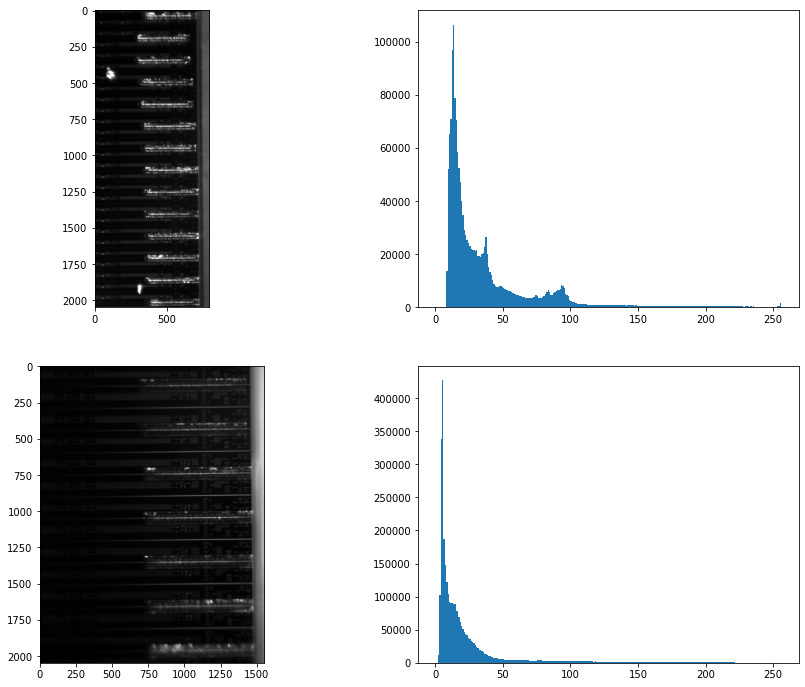

In [51]:
### Preprocessing: Grey scale, blur, split image to get fiber and concatenate images

array1 = get_array('C:/Users/MARIELENA/visionautomation/Photos/Photo_Fiber_Obj_10X.tif')
array2 = get_array('C:/Users/MARIELENA/visionautomation/Photos/Photo_Fiber_Obj_20X.tif') # I will keep this, as another example

#cv.imshow('Original image', rescale(array, scale = 0.48))
gray1 = cv.cvtColor(array1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(array2, cv.COLOR_BGR2GRAY)
blur1 = cv.GaussianBlur(gray1,(5,5),cv.BORDER_DEFAULT)  
blur2 = cv.GaussianBlur(gray2,(5,5),cv.BORDER_DEFAULT)  

img_left1, img_right1 = img_separator (blur1)
img_left2, img_right2 = img_separator (blur2)


plt.figure(figsize=[15,12])
plt.subplot(221); plt.imshow(img_left1, cmap='gray')
plt.subplot(222); plt.hist(img_left1.ravel(), 256, [0,256]) #Remember: 256 is white
plt.subplot(223); plt.imshow(img_left2, cmap='gray')
plt.subplot(224); plt.hist(img_left2.ravel(), 256, [0,256]) ##second 
plt.show()


[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]] 63.0


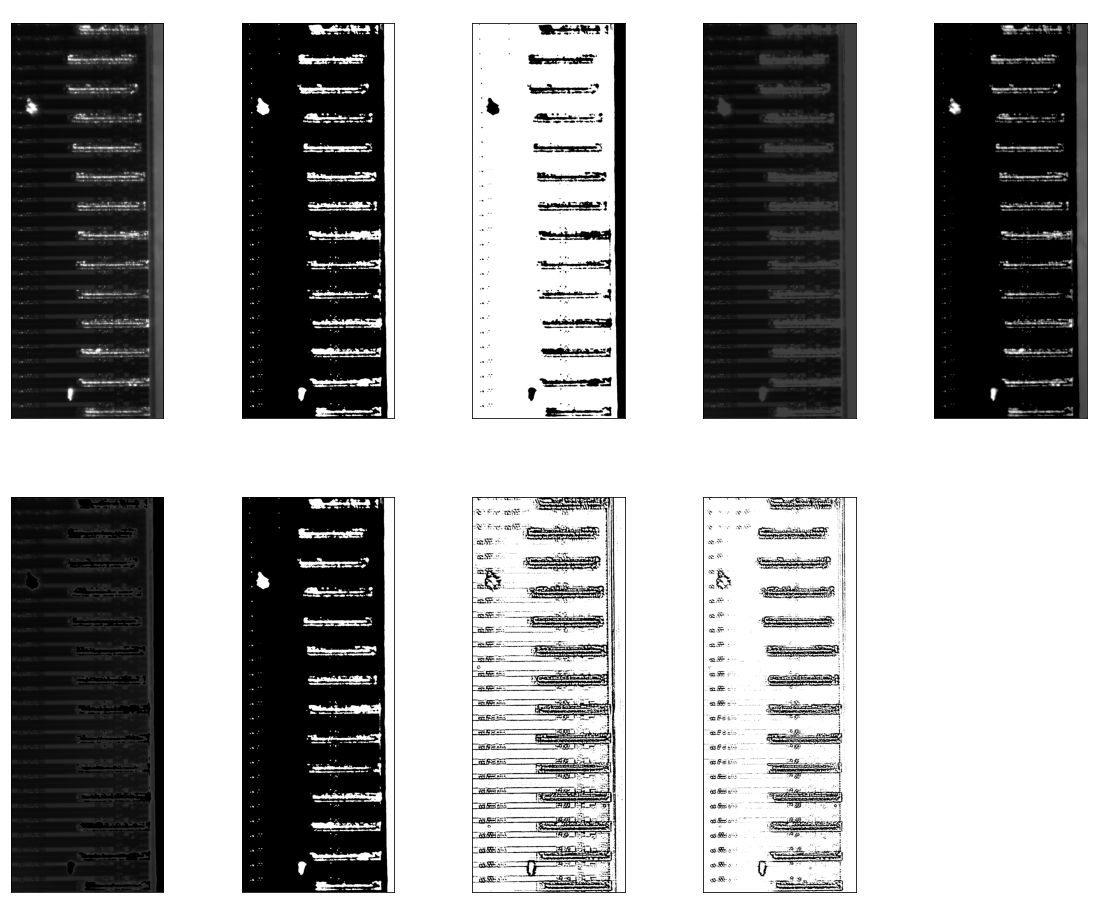

In [69]:
### Thresholding of first figure
 
thresh = 63 ## follow histogram to find a good value
x = 11
y = 2

ret1,thresh1 = cv.threshold(img_left1,thresh,255,cv.THRESH_BINARY)
ret2,thresh2 = cv.threshold(img_left1,thresh,255,cv.THRESH_BINARY_INV)
ret3,thresh3 = cv.threshold(img_left1,thresh,255,cv.THRESH_TRUNC)
ret4,thresh4 = cv.threshold(img_left1,thresh,255,cv.THRESH_TOZERO)
ret5,thresh5 = cv.threshold(img_left1,thresh,255,cv.THRESH_TOZERO_INV)
ret6,thresh6 = cv.threshold(img_left1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
print( "{} {}".format(thresh6,ret6) )
athresh1 = cv.adaptiveThreshold(img_left1,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,x,y)
athresh2 = cv.adaptiveThreshold(img_left1,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,x,y)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV','OTSU','BINARY_MEAN','BINARY_GAUSSIAN']
images = [img_left1, thresh1, thresh2, thresh3, thresh4, thresh5, thresh6, athresh1, athresh2]

plt.figure(figsize=[20,16])
for i in range(9):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i], color = 'white')
    plt.xticks([]),plt.yticks([])
plt.show()


In [ ]:
### Area of interest 